## Analyze A/B Test Results

This project aims to strengthen statistical skills of data analysts, which includes Probability, A/B Testing and Regression.    
It is designed as a tutorial with step by step guided for beginners.  

## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that data analysts get some practice working with the difficulties of these tests

For this project, Data Analysts will be working to understand the results of an A/B test run by an e-commerce website.  The goal is to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.


<a id='probability'></a>
#### Part I - Probability

To get started, let's import some libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df=pd.read_csv('ab_data.csv')
df.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


b. Find the number of rows in the dataset.

In [40]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [41]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [42]:
df.query('converted==1').user_id.nunique()/df.user_id.nunique()

0.12104245244060237

e. The number of times the `new_page` and `treatment` don't line up.

In [19]:
df.query('group=="treatment" & landing_page!="new_page"').shape[0] + df.query('group!="treatment" & landing_page=="new_page"').shape[0]

3893

f. Find missing values in rows

In [14]:
df.isnull().any()

user_id         False
timestamp       False
group           False
landing_page    False
converted       False
dtype: bool

`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.

a. Create a new dataset stored the new dataframe in **df2**.

In [4]:
df2=df.drop(df[((df['group']=='treatment')!=(df['landing_page']=='new_page'))==True].index)

In [5]:
df2.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [5]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** to answer questions about the datasets

a. How many unique **user_id**s are in **df2**?

In [94]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [5]:
df2[df2.user_id.duplicated()==True]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


c. What is the row information for the repeat **user_id**? 

In [7]:
df2[df2.user_id.duplicated()==True].index.values

array([2893])

d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [6]:
df2.drop(df2[df2.user_id.duplicated()==True].index, inplace=True)

4    
a. What is the probability of an individual converting regardless of the page they receive?

In [8]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [36]:
ctr_converted=df2.query('group=="control"').converted.mean()
ctr_converted

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [37]:
trm_converted=df2.query('group=="treatment"').converted.mean()
trm_converted

0.11880806551510564

d. What is the probability that an individual received the new page?

In [123]:
df2.query('landing_page=="new_page"').shape[0]/df2.shape[0]

0.5000619442226688

e. Is there evidence that one page leads to more conversions?

**Answer:** There is no evidence suggesting that the new pages leads to more conversions. Indeed, the conversion probability of Treatment group is smaller than that of Control group, i.e 11.88% < 12.04%

<a id='ab_test'></a>
### Part II - A/B Test

Because of the time stamp associated with each event, we could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider we need to make the decision just based on all the data provided.  If we want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should our null and alternative hypotheses be?  We can state our hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

**Answer:**   
            $H_0: p_{old} \geq p_{new}$  
            $H_1: p_{old} < p_{new}$
            

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

The necessary parts of this simulation is provided as below.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [11]:
p_new=df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [12]:
p_old=df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [14]:
#n_new is the number of people that received the new page
n_new=df2.query('group=="treatment"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [15]:
#n_old is the number of people that received the old page
n_old=df2.query('group=="control"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [32]:
#Approach 1: Using binomial function to get an array of the number of success events
#with p_new rate from n_new trials, which is performed 10000 time. Divide this array
# of 10000 elements to the number of trials to find new rates. 
new_page_converted1=np.random.binomial(n_new,p_new,10000)/n_new
old_page_converted1=np.random.binomial(n_old,p_old,10000)/n_old
#Find  p_new -p_old 
new_page_converted1.mean()-old_page_converted1.mean()

7.6619270020089614e-06

In [22]:
#Approach 2: Using random.choice function to get an array of 0 or 1 with 
#p-new rate from n_new trials. Take mean of this output array to get the 
# new rate for p_new & p_old

new_page_converted = np.random.choice([0, 1], size = n_new, p = [1-p_new, p_new])
new_page_converted

array([0, 0, 0, ..., 0, 0, 0])

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [23]:
old_page_converted = np.random.choice([0, 1], size = n_old, p = [1-p_old, p_old])
old_page_converted

array([1, 0, 0, ..., 0, 0, 0])

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [28]:
(new_page_converted==1).mean()-(old_page_converted==1).mean()

-9.8467984172637135e-05

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [33]:
for i in range (10000):
    new_page_converted2=np.random.binomial(n_new,p_new,10000)/n_new
    old_page_converted2=np.random.binomial(n_old,p_old,10000)/n_old
    p_diffs=new_page_converted2-old_page_converted2
    

i. Plot a histogram of the **p_diffs**. 

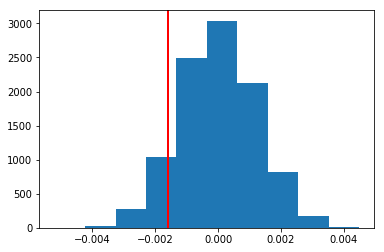

In [38]:
plt.hist(p_diffs)
plt.axvline(trm_converted-ctr_converted, color='r', linewidth=2)

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [39]:
(p_diffs > (trm_converted-ctr_converted)).mean()

0.90800000000000003

k. Explain the value mean in terms of whether or not there is a difference between the new and old pages?

**Answer:** The value of the p_diffs in j. is p-value of the sampling distribution of the difference between converted rates of the new vs old pages.
This $p_{value} > \alpha = 0.05$ , meaning that it is failed to reject Null hypothesis $H_0: p_{new}=p_{old}$. Therefore, there is evidence to conclude that there is no difference between the new and old pages

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance.  Calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [18]:
import statsmodels.api as sm

convert_old = df2.query('group=="control"').converted.mean()
convert_new = df2.query('group=="treatment"').converted.mean()
n_old = df2.query('group=="control"').shape[0]
n_new = df2.query('group=="treatment"').shape[0]

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.

In [43]:
z_score, p_value = sm.stats.proportions_ztest([convert_old, convert_new], [n_old, n_new])
z_score, p_value

(0.0032875796753531767, 0.99737689565979126)

n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer:** This z-score is associated with p-value, therefore; we can interpret either one. p-value > Type I error $\alpha=0.05$ for one-sided hypothesis testing ($H_1: p_{new} > p_{old}$) concludes that it's failed to reject Null hypothesis. There is no difference between the conversion rates of the old and new pages.  
Although p-values is a bit different between 2 approaches (it's reasonable), they all lead to the same conclusion in parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, the result we acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer:** Logistic Regression

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, we first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [7]:
df2.head(3)

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0


In [8]:
df2['intercept']=1
df2['ab_page']=pd.get_dummies(df['group'])['treatment']
df2.head(3)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1


c. Use **statsmodels** to import our regression model.  Instantiate the model, and fit the model using the two columns we created in part **b.** to predict whether or not an individual converts.

In [19]:
from statsmodels import regression
lg=sm.Logit(df2['converted'],df2[['intercept','ab_page']])
results=lg.fit()


Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of our model below, and use it as necessary to answer the following questions.

In [59]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 13 Sep 2018   Pseudo R-squ.:               8.077e-06
Time:                        16:55:12   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value we found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with our regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer:** The p-value associated with ab_page is 0.19 which is different from the previous ones. Although these p-values all suggest not to reject the Null hypothesis. They answer different hypothesis testing questions.  
* The P-value in the Part II suggests not to reject the Null hypothesis that the converstion rates associated with the new and old landing pages are the same. Meanwhile, the p-value in this Logistic Regresson suggests not to reject the Null hypothesis that the conversion rate is not (statistically significant) predicted by the type of landing pages.     
* The alternative hypothesis of the Part II suggests that the conversion rate of the new landing page is higher than that of the old landing page. Meanwhile, the alternative hypothesis of the Regresson Model suggests that the conversion rate is (statistically significant) predicted by the type of landing pages.  

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer:** Other factors should be considered for this regression model because the current model is not statistically significant. Indeed, the intercept has no meaning in this model and the p_value for the only independent variable (ab_page) $p_{value} = 0.19 > \alpha = 0.05$ suggests that the conversion rate is not (statistically significant) predicted by the type of landing page.  
However, there are some disadvantages to adding new factors into this model. For example, the new factors may be correlated or has the collinearity with the current independent variable. This could happen when the new factors come from a repeated or relevant measurements with the ones to identify the current independent variable.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. We will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows. 

Does it appear that country had an impact on conversion?

In [9]:
df3=pd.read_csv('countries.csv')
df3.head(3)

,user_id,country
0,834778,UK
1,928468,US
2,822059,UK


In [16]:
df2=df2.join(df3.set_index('user_id'),on='user_id')
df2[['CA','UK']]=pd.get_dummies(df2['country'])[['CA','UK']]
df2.head(2)

,user_id,timestamp,group,landing_page,converted,intercept,ab_page,country,CA,UK
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0,US,0,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0,US,0,0


In [20]:
lg1=sm.Logit(df2['converted'],df2[['intercept','CA','UK']])
results1=lg1.fit()
results1.summary()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Fri, 14 Sep 2018   Pseudo R-squ.:               1.521e-05
Time:                        08:03:22   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9967      0.007   -292.314      0.000      -2.010      -1.983
CA            -0.0408      0.027     -1.518      0.129      -0.093       0.012
UK             0.0099      0.013      0.746      0.456      -0.016       0.036
==============================================================================
"""

**Answer:** The p_values of both CA and UK,  $p_{value} > \alpha =0.05$ suggest that country has no statistically significant impact on the conversion rate. In other words, the converstion rate is not predicted by the country 

h. Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and our conclusions based on the results.

In [21]:
lg2=sm.Logit(df2['converted'],df2[['intercept','ab_page','CA','UK']])
results2=lg2.fit()
results2.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Fri, 14 Sep 2018   Pseudo R-squ.:               2.323e-05
Time:                        08:04:04   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9893      0.009   -223.763      0.000      -2.007      -1.972
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
CA            -0.0408      0.027     -1.516      0.130      -0.093       0.012
UK             0.0099      0.013      0.743      0.457      -0.016       0.036
==============================================================================
"""

**Answer:** The p-values of all the independent variables suggest that both type of pages and associated countries have no statistically significant impact on the conversion rate. In other words, the converstion rate is not predicted by the country or the type of page. In conclusion, it's failed to reject the Null hypothesis that the conversion rates are not (statistically significant) predicted by coutry and type of pages

## Part IV 
**Optimize the regression model**
* I was intended to create dummies variables for different aspects of time to understand the influences associated with time on the conversion. However the testing duration is only 21 days, which leads to only way (I think) to code the timeseries to binominal values, either odd or even day. In my opinion, it does not make sense for business to understand the influences of odd/even days to the conversion rate. Therefore, I decided to try another method as below  
* considering only datapoints that occur in the second haft of the testing timeframe to reduce the possible Novelty effect and change aversion.

In [37]:
df2['timestamp']=pd.to_datetime(df2['timestamp'])
df2.timestamp.head(3),df2.timestamp.tail(3)

(0   2017-01-21 22:11:48.556739
 1   2017-01-12 08:01:45.159739
 2   2017-01-11 16:55:06.154213
 Name: timestamp, dtype: datetime64[ns], 294475   2017-01-22 11:45:03.439544
 294476   2017-01-15 01:20:28.957438
 294477   2017-01-16 12:40:24.467417
 Name: timestamp, dtype: datetime64[ns])

In [41]:
df2['timestamp'].max()-df2['timestamp'].min()

Timedelta('21 days 23:59:49.081927')

In [76]:
df3=df2[df2['timestamp'] > df2.timestamp.quantile(0.5)]

In [77]:
lg3=sm.Logit(df3['converted'],df3[['intercept','ab_page','CA','UK']])
results3=lg3.fit()
results3.summary()

Optimization terminated successfully.
         Current function value: 0.367960
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               145292
Model:                          Logit   Df Residuals:                   145288
Method:                           MLE   Df Model:                            3
Date:                Fri, 14 Sep 2018   Pseudo R-squ.:               5.183e-05
Time:                        09:01:32   Log-Likelihood:                -53462.
converged:                       True   LL-Null:                       -53464.
                                        LLR p-value:                    0.1362
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9772      0.013   -158.060      0.000      -2.002      -1.953
ab_page       -0.0265      0.016     -1.646      0.100      -0.058       0.005
CA            -0.0430      0.038     -1.130      0.258      -0.118       0.032
UK             0.0202      0.019      1.076      0.282      -0.017       0.057
==============================================================================
"""

**Conclusion:** The p-values suggest the same conclusion not to reject the Null hypothesis, meaning that the conversion rates are not well predicted by this model. This model looks very similar to the previous one, which indicates that the testing timeframe has minimal impacts on the model 

Now, try the regression model with only one independent variable (type of landing page) in the same second half of the testing timeframe as below

In [79]:
lg3x=sm.Logit(df3['converted'],df3[['intercept','ab_page']])
results3x=lg3x.fit()
results3x.summary()

Optimization terminated successfully.
         Current function value: 0.367970
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               145292
Model:                          Logit   Df Residuals:                   145290
Method:                           MLE   Df Model:                            1
Date:                Fri, 14 Sep 2018   Pseudo R-squ.:               2.553e-05
Time:                        09:04:54   Log-Likelihood:                -53463.
converged:                       True   LL-Null:                       -53464.
                                        LLR p-value:                   0.09848
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9742      0.011   -174.286      0.000      -1.996      -1.952
ab_page       -0.0266      0.016     -1.652      0.098      -0.058       0.005
==============================================================================
"""

**Conclusion:** The p-value of ab_page suggests the same conclusion not to reject the Null hypothesis, meaning that the conversion rates are not well predicted by this model. However the p-value looks better than previous ones. Would reduce the testing timeframe improve it?  
Try with the datapoints in the last 25% of the testing timeframe

In [78]:
df4=df2[df2['timestamp'] > df2.timestamp.quantile(0.75)]
lg4=sm.Logit(df4['converted'],df4[['intercept','ab_page','CA','UK']])
results4=lg4.fit()
results4.summary()

Optimization terminated successfully.
         Current function value: 0.365770
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                72646
Model:                          Logit   Df Residuals:                    72642
Method:                           MLE   Df Model:                            3
Date:                Fri, 14 Sep 2018   Pseudo R-squ.:               3.936e-05
Time:                        09:03:17   Log-Likelihood:                -26572.
converged:                       True   LL-Null:                       -26573.
                                        LLR p-value:                    0.5536
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9940      0.018   -112.089      0.000      -2.029      -1.959
ab_page       -0.0231      0.023     -1.009      0.313      -0.068       0.022
CA             0.0308      0.053      0.585      0.559      -0.073       0.134
UK             0.0245      0.027      0.919      0.358      -0.028       0.077
==============================================================================
"""

**Conclusion:** The p-values suggest the same conclusion not to reject the Null hypothesis, meaning that the conversion rates are not well predicted by this model. This time, the model looks worse than the previous ones, again suggesting that the testing timeframe has minimal impacts on the model. 

Now, try the regression model with only one independent variable (type of landing page) in the last 25% of the testing timeframe as below

In [80]:
lg4x=sm.Logit(df4['converted'],df4[['intercept','ab_page']])
results4x=lg4x.fit()
results4x.summary()

Optimization terminated successfully.
         Current function value: 0.365778
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:                72646
Model:                          Logit   Df Residuals:                    72644
Method:                           MLE   Df Model:                            1
Date:                Fri, 14 Sep 2018   Pseudo R-squ.:               1.942e-05
Time:                        09:06:25   Log-Likelihood:                -26572.
converged:                       True   LL-Null:                       -26573.
                                        LLR p-value:                    0.3096
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9863      0.016   -123.427      0.000      -2.018      -1.955
ab_page       -0.0232      0.023     -1.016      0.310      -0.068       0.022
==============================================================================
"""

**Conclusion:** The p-values looks worse now. It still suggests the same conclusion not to reject the Null hypothesis, meaning that the conversion rates are not well predicted by this model.    
As can be seen from the different regression models, the conversion rates are not statistically significant predicted by type of landing page or country, even within a certain testing timeframe.  
I suggest to increase the testing timeframe to several months so that dummies variables of timeseries by month can be directly added into the model

<a id='conclusions'></a>
## Finishing Up



In [81]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0